# Chatbot with message summarization & external database memory (Postgres)

## Review

We've covered how to customize graph state schema and reducer.

We've also shown a number of tricks for trimming or filtering messages in graph state.

We've used these concepts in a Chatbot with memory that produces a running summary of the conversation.

## Goals

But, what if we want our Chatbot to have memory that persists indefinitely?

Now, we'll introduce some more advanced checkpointers that support external databases.

Here, we'll use the Postgres checkpointer!

## Dependencies

In [1]:
from psycopg import AsyncConnection, rows
from langgraph.checkpoint.postgres.aio import AsyncPostgresSaver
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_ollama import ChatOllama
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, RemoveMessage
from dotenv import load_dotenv
from IPython.display import display, Image
import os
from pathlib import Path
from pprint import pprint
import asyncio

## Postgres

In [2]:
current = Path(os.getcwd())

db_env_path = current.parent.parent.parent / 'db.env'
print(db_env_path)

load_dotenv(dotenv_path=db_env_path, encoding='utf-8-sig')

db_config= {
    "dbname": os.getenv("POSTGRES_DB"),
    "user": os.getenv("POSTGRES_USER"),
    "password": os.getenv("POSTGRES_PASSWORD"),
    "host": os.getenv("POSTGRES_HOST"),
    "port": os.getenv("POSTGRES_PORT")
}

try:
    conn = await AsyncConnection.connect(**db_config, row_factory=rows.dict_row, keepalives=1,
    keepalives_idle=30,  # Time in seconds before sending keepalive probes
    keepalives_interval=10,  # Time between keepalive probes
    keepalives_count=5)
    await conn.set_autocommit(True)
    print("Connected successfully with autocommit enabled!")
except Exception as e:
    print(f"Connection error details: {str(e)}")

c:\Users\guilh\Trabalho\AILabz\repositories\langgraph_academy\db.env
Connected successfully with autocommit enabled!


In [3]:
memory = AsyncPostgresSaver(conn)
# Setup the checkpointer
try:
    await memory.setup()
    print("Checkpointer setup completed successfully.")
except Exception as e:
    print(f"An error occurred during checkpointer setup: {str(e)}")

Checkpointer setup completed successfully.


## Graph


In [4]:
llm = ChatOllama(
    model="llama3.1",
    base_url="http://localhost:11434",
    temperature=0.8,
    max_tokens=1000
)

In [5]:
class State(MessagesState):
    summary: str

In [6]:
def call_model(state: State):

    summary = state.get("summary","")

    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    response = llm.invoke(messages)
    return {
        "messages": response
    }


def summarize_conversation(state: State):

    summary = state.get("summary","")

    if summary:

        summary_message = (
            f"This is summary of conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][-2:]]
    return {"summary":response.content, "messages": delete_messages}


def should_continue(state:State):

    """Return the next node to execute"""
    messages = state["messages"]

    if len(messages) > 6:
        return "summarize_conversation"
    return END

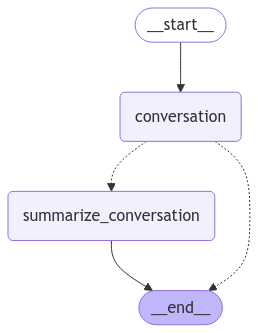

In [7]:
builder = StateGraph(State)
builder.add_node("conversation", call_model)
builder.add_node("summarize_conversation", summarize_conversation)

# Add the edges
builder.add_edge(START,"conversation")
builder.add_conditional_edges("conversation", should_continue)
builder.add_edge("summarize_conversation", END)

# Compile the graph
graph = builder.compile(checkpointer=memory)

# Display it
display(Image(graph.get_graph().draw_mermaid_png()))


Now we can invoke our graph several times

In [8]:
# Create a thread
config = {"configurable":{"thread_id":"1"}}

In [34]:


try:
    # Start the conversation
    input_message = HumanMessage("Hello, I'm Guilherme")
    output = await graph.ainvoke({"messages": [input_message]}, config=config)
    for m in output["messages"][-1:]:
        m.pretty_print()

    # Continue the conversation
    input_message = HumanMessage("What is my name?")
    output = await graph.ainvoke({"messages": [input_message]}, config=config)
    for m in output["messages"][-1:]:
        m.pretty_print()

    # Continue the conversation
    input_message = HumanMessage("I like math and physics")
    output = await graph.ainvoke({"messages": [input_message]}, config=config)
    for m in output["messages"][-1:]:
        m.pretty_print()

except Exception as e:
    print(f"An error occurred: {str(e)}")
    await conn.rollback()

================================== Ai Message ==================================

Olá Guilherme! Nice to meet you. How can I assist you today?
================================== Ai Message ==================================

Your name is Guilherme! What's your surname, by the way? (In Portuguese, we usually use both first and last names)
================================== Ai Message ==================================

That's great to hear! Math and physics are fascinating subjects. Do you have a favorite area within these subjects, such as algebra, geometry, calculus, electromagnetism, or quantum mechanics?

Also, do you have any experience with programming languages that can help with problem-solving in math and physics, like Python, MATLAB, or C++?


## Persising State

Using database like PostgresSQL, SQLite, etc means state is persisted at disk.

So if I restart the notebook kernel, I'll still be able to retrieve our conversation from thread "1".

In [10]:
graph_state = await graph.aget_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="Hello, I'm Guilherme", additional_kwargs={}, response_metadata={}, id='7d033989-cb4c-42b8-aa39-27eb6f52203e'), AIMessage(content='Olá Guilherme! Nice to meet you. How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2025-01-06T17:07:14.0244657Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5752112900, 'load_duration': 4730341800, 'prompt_eval_count': 17, 'prompt_eval_duration': 371000000, 'eval_count': 19, 'eval_duration': 649000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-12dad573-6ecd-467b-bcdd-8f33f7879a17-0', usage_metadata={'input_tokens': 17, 'output_tokens': 19, 'total_tokens': 36}), HumanMessage(content='What is my name?', additional_kwargs={}, response_metadata={}, id='69ac1176-bd08-4757-b7cb-719f2d60b2bc'), AIMessage(content="Your name is Guilherme! What's your surname, by the way? (In Portuguese, we us

## Some pinpoints

As I was investigating how PostgresSaver works I found two things that bothered me:

- There is no documentation on how the tables are organized in the database to store the checkpoints
- There is no direct API to delete a checkpoint, only to create, read and update.

So I decided to adrees these issues here

### The data organization

The database model for the PostgreSQL checkpointer in LangGraph is designed to store, manage, and retrieve checkpoints representing the state of a conversation or workflow at various points in time. Here's a detailed explanation of the schema:

---

### Key Tables

#### 1. **`checkpoint_migrations`**
- **Purpose**: Tracks the version of database migrations.
- **Columns**:
  - `v`: Integer, primary key, represents the migration version applied.

---

#### 2. **`checkpoints`**
- **Purpose**: Stores the main checkpoint data, including metadata and hierarchical relationships.
- **Columns**:
  - `thread_id`: Text, identifier for a conversation or workflow thread.
  - `checkpoint_ns`: Text, namespace for the checkpoint (default is empty string).
  - `checkpoint_id`: Text, unique ID for the checkpoint within a thread.
  - `parent_checkpoint_id`: Text, ID of the parent checkpoint (for hierarchical relationships or versioning).
  - `type`: Text, type of checkpoint (could be a specific type of workflow or conversation state).
  - `checkpoint`: JSONB, stores the serialized checkpoint data.
  - `metadata`: JSONB, additional metadata about the checkpoint (default is an empty JSON object).
- **Primary Key**: Combination of `thread_id`, `checkpoint_ns`, and `checkpoint_id`.

---

#### 3. **`checkpoint_blobs`**
- **Purpose**: Stores blobs (binary large objects) associated with checkpoints for specific channels and versions.
- **Columns**:
  - `thread_id`: Text, thread identifier.
  - `checkpoint_ns`: Text, namespace for the checkpoint.
  - `channel`: Text, name of the channel the blob is associated with (e.g., a specific data stream or module).
  - `version`: Text, version of the blob.
  - `type`: Text, type of the blob (e.g., JSON, binary, or a specific data type).
  - `blob`: BYTEA, the actual binary data.
- **Primary Key**: Combination of `thread_id`, `checkpoint_ns`, `channel`, and `version`.

---

#### 4. **`checkpoint_writes`**
- **Purpose**: Tracks writes to checkpoints, enabling reconstruction or rollback of states.
- **Columns**:
  - `thread_id`: Text, thread identifier.
  - `checkpoint_ns`: Text, namespace for the checkpoint.
  - `checkpoint_id`: Text, identifier for the checkpoint being written to.
  - `task_id`: Text, ID of the task associated with the write operation.
  - `idx`: Integer, index to preserve the order of writes.
  - `channel`: Text, channel the write is associated with.
  - `type`: Text, type of data being written.
  - `blob`: BYTEA, the binary data written.
- **Primary Key**: Combination of `thread_id`, `checkpoint_ns`, `checkpoint_id`, `task_id`, and `idx`.

---

### How This Schema Works in Practice

1. **Checkpoints**:
   - A checkpoint represents a snapshot of the conversation or workflow.
   - Checkpoints have hierarchical relationships (parent-child).

2. **Blobs**:
   - Associated with specific checkpoints and channels, blobs store supplementary binary data (e.g., results, intermediate data).

3. **Writes**:
   - Tracks changes made to checkpoints, allowing stepwise updates and potential reconstruction of states.

4. **Metadata**:
   - Facilitates filtering, searching, and managing checkpoints without needing to decode the main checkpoint data.

5. **Indexes**:
   - Indexes on `thread_id` columns across tables improve query performance for workflows/conversations scoped by a thread.

---

### Common Use Cases

- **Storing State**: Use checkpoints to capture the state of a conversation or task.
- **Versioning**: Store multiple versions of the state using blobs and checkpoint relationships.
- **Retrieving Data**: Efficiently query for the latest or specific states, including metadata and related binary data.
- **Reconstruction**: Use `checkpoint_writes` to reconstruct the sequence of operations applied to a checkpoint.

---

### For Deletion

In the code below, as I used `AsyncConnection`, I hade to create async / await operations.

Nonetheless, `PostgresSaver` allows you to access the `Connection` object you passed as an argument to instantiate the saver.

So you can create a `cursor` object from the connection `PostgresSaver.conn.cursor()` and then use it to execute a deletion operation.

Finnaly, you will commit the updates to the database using the `commit` method from `Connection`.

In the example below you can delete the entire conversation by passing a thread id, but you can customize your query to delete by other filters.

In [26]:
async def delete_conversation(thread_id: str):
    async with memory.conn.cursor() as cursor:
        await cursor.execute("""
            DELETE FROM checkpoints WHERE thread_id=%s;
        """, (thread_id,))
        await cursor.execute("""DELETE FROM checkpoint_blobs WHERE thread_id=%s""",(thread_id,))
        await cursor.execute("""DELETE FROM checkpoint_writes WHERE thread_id=%s""",(thread_id,))
        conn.commit()

# Run the coroutine
await delete_conversation("1")


None


C:\Users\guilh\AppData\Local\Temp\ipykernel_23920\558580847.py:14: RuntimeWarning: coroutine 'AsyncConnection.commit' was never awaited
  conn.commit()
